## Фреймворк PyTorch для разработки искусственных нейронных сетей
### Курсовая работа - Hand Gesture Recognition Database
#### Acquired by Leap Motion

![image](dataset-cover.png)  

Нужно написать приложение, которое будет считывать и выводить кадры с веб-камеры. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре. После этого, человек показывает жесты руками, а алгоритм должен считать их и определенным образом реагировать на эти жесты.   
На то, как система будет реагировать на определенные жесты - выбор за вами. Например, на определенный жест (жест пис), система будет здороваться с человеком. На другой, будет делать скриншот экрана. И т.д.  
Для распознавания жестов, вам надо будет скачать датасет  https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.  

In [2]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:77% !important; }</style>"))

In [3]:
import os
import time
import cv2 #Image handling library

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

from PIL import Image
from torch.autograd import Variable

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Часть 1. Подготовка данных

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# dst_path = "/content/drive/MyDrive/Colab Notebooks/my_projects/archive.zip"

In [8]:
# from zipfile import ZipFile
# zipfile = ZipFile(dst_path)
# zipfile.extractall()

In [9]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']

In [10]:
# Модуль glob находит все пути, совпадающие с заданным шаблоном в соответствии с правилами. 
# glob.glob(pathname) возвращение список (возможно, пустой) путей, соответствующих шаблону pathname.
import glob
images = glob.glob('D:/kaggle/leapGestRecog/**/**/*.png')
# images = glob.glob('/content/leapGestRecog/**/**/*.png')

# extract label number from filename and reduce by 1 so that it ranges from 0 to 9 (instead of 1 to 10). Otherwise loss function will complain
label = [int(os.path.basename(i).split('_')[2])-1 for i in images]

In [11]:
train_transformer = transforms.Compose([
                    transforms.Resize(64),              # resize the image to 64x64 
                    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
                    transforms.ToTensor()])             # transform it into a PyTorch Tensor

test_transformer =   transforms.Compose([
                    transforms.Resize(64),              # resize the image to 64x64 
                    transforms.ToTensor()]) 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, label, test_size = 0.3, random_state=0)

In [13]:
class SIGNSDataset(Dataset):
    def __init__(self, filenames, labels, transform):      
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #return size of dataset
        return len(self.filenames)

    def __getitem__(self, idx):
        #open image, apply transforms and return with label
        image = Image.open(self.filenames[idx])  # PIL image
        image = self.transform(image)
        return image, self.labels[idx]

In [14]:
train_dataset = SIGNSDataset(X_train, y_train, train_transformer)
test_dataset = SIGNSDataset(X_test, y_test, test_transformer)

In [15]:
batch_size = 32
lr = 0.01
train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size)

In [16]:
def show_batch(dl):
    for img, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 14))
        ax.set_xticks([]); ax.set_yticks([])
        print(img[0].shape)
        ax.imshow(make_grid(img[:20], nrow=4).permute(1, 2, 0))
        break

torch.Size([1, 64, 170])


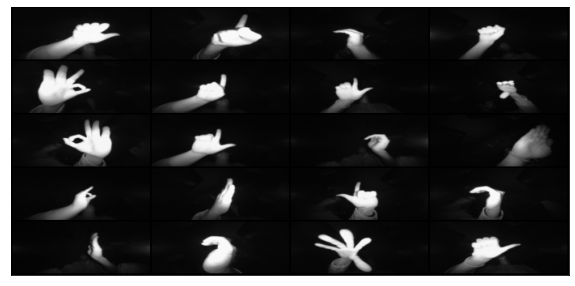

In [17]:
show_batch(train_dl)

### Часть 2. Создание модели

In [18]:
# Model Arch
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(79680, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [19]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [20]:
epochs = 25

In [21]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

25 epochs, 438 total_steps per epoch


### Часть 3. Обучение

In [21]:
def fit(model, epochs):

    epoch_losses = []
    epoch_acc = []
    epoch_val_losses = []
    epoch_val_acc = []
    bundle = 20

    print("State_dict модели: ")
    for param in model.state_dict():
        print("\t", param,": ", model.state_dict()[param].size())

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        cum_loss = []
        cum_acc = []

        # print(f'Эпоха: {epoch+1}')
        time1 = time.time()
        model.train()
        for i, data in enumerate(train_dl, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            cum_loss.append(loss.item())

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            cum_acc.append(correct / total)

        time2 = time.time()
        epoch_losses.append(np.mean(cum_loss))
        epoch_acc.append(np.mean(cum_acc))

        cum_loss = []
        cum_acc = []
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for i, data in enumerate(test_dl, 0):
                inputs, labels = data
                inputs = inputs.to(device) 
                labels = labels.to(device) 

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                cum_loss.append(loss.item())

                # Отслеживание точности
                total = labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct = (predicted == labels).sum().item()
                cum_acc.append(correct / total)

        epoch_val_losses.append(np.mean(cum_loss))
        epoch_val_acc.append(np.mean(cum_acc))
        print(f"Эпоха: {epoch+1}   loss: {epoch_losses[-1]:.5f}   "
              f"accuracy: {epoch_acc[-1]*100:.3f}%   "
              f"loss_val: {epoch_val_losses[-1]:.5f}   "
              f"accuracy_val: {epoch_val_acc[-1]*100:.3f}%   "
              f"time = {time2-time1:.2f} c")
        
    return {"epoch_losses": epoch_losses, 
            "epoch_val_losses": epoch_val_losses, 
            "epoch_acc": epoch_acc, 
            "epoch_val_acc": epoch_val_acc}

In [22]:
history = fit(model, epochs)

State_dict модели: 
	 conv1.weight :  torch.Size([32, 1, 3, 3])
	 conv1.bias :  torch.Size([32])
	 conv2.weight :  torch.Size([32, 32, 3, 3])
	 conv2.bias :  torch.Size([32])
	 fc1.weight :  torch.Size([128, 79680])
	 fc1.bias :  torch.Size([128])
	 fc2.weight :  torch.Size([10, 128])
	 fc2.bias :  torch.Size([10])
Эпоха: 1   loss: 1.69740   accuracy: 40.190%   loss_val: 0.99291   accuracy_val: 66.855%   time = 51.46 c
Эпоха: 2   loss: 0.92360   accuracy: 67.580%   loss_val: 0.50904   accuracy_val: 82.447%   time = 45.88 c
Эпоха: 3   loss: 0.65624   accuracy: 77.148%   loss_val: 0.48821   accuracy_val: 83.411%   time = 45.55 c
Эпоха: 4   loss: 0.49679   accuracy: 82.705%   loss_val: 0.21977   accuracy_val: 92.969%   time = 45.64 c
Эпоха: 5   loss: 0.41935   accuracy: 85.852%   loss_val: 0.14553   accuracy_val: 96.443%   time = 45.50 c
Эпоха: 6   loss: 0.36492   accuracy: 87.422%   loss_val: 0.11647   accuracy_val: 96.376%   time = 45.49 c
Эпоха: 7   loss: 0.31725   accuracy: 89.048%   

In [23]:
def graph(hist):
    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)

    len_l = len(hist["epoch_losses"])

    plt.plot(np.arange(1, len_l + 1), hist["epoch_losses"], 'go-', label='train loss')
    plt.plot(np.arange(1, len_l + 1), hist["epoch_val_losses"], 'ro-', label='validation loss')

    plt.legend(loc="upper right")
    plt.grid(color="lightgrey")
    plt.title('Сравнение train и valid loss')

    ax = plt.subplot(1, 2, 2)

    plt.plot(np.arange(1, len_l + 1), hist["epoch_acc"], 'go-', label='train accuracy')
    plt.plot(np.arange(1, len_l + 1), hist["epoch_val_acc"], 'ro-', label='validation accuracy')

    plt.legend(loc="lower right")
    plt.grid(color="lightgrey")
    plt.title('Сравнение train и valid accuracy')
    plt.show()

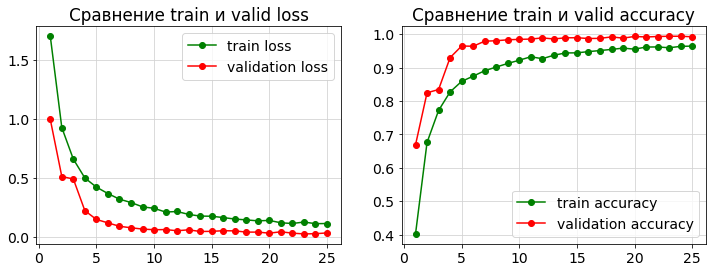

In [24]:
graph(history)

In [25]:
torch.save(model.state_dict(), '/content/hand_gesture_recognitionemotion.pth')

### Часть 4. Результаты

In [22]:
net = Net().to(device)
# net.load_state_dict(torch.load('/content/hand_gesture_recognitionemotion.pth'))
net.load_state_dict(torch.load('./hand_gesture_recognitionemotion.pth', map_location=torch.device('cpu')))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=79680, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

correct: 32


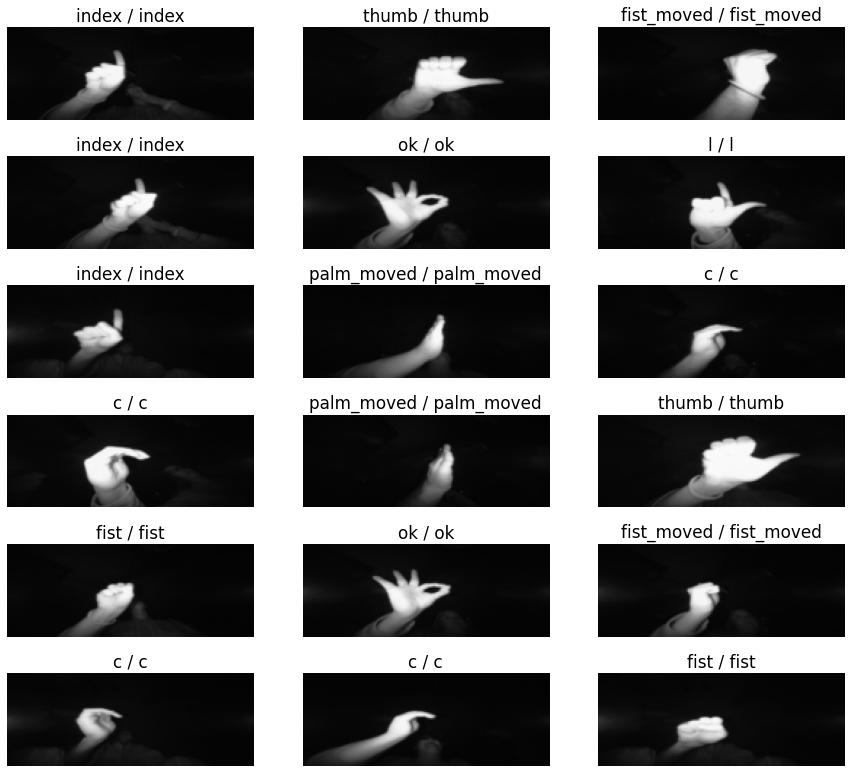

In [23]:
data_iter = iter(test_dl)

img, labels = data_iter.next()

# print(f"labels: {labels}")

model.eval()
with torch.no_grad():
    inputs = img.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    # Отслеживание точности
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    # print(f"predicted: {predicted}")
    correct = (predicted == labels).sum().item()
    print(f"correct: {correct}")

plt.figure(figsize=(15, 21))
for i in range(batch_size):
    ax = plt.subplot(9, 3, i+1)
    
    plt.imshow(cv2.cvtColor(img[i, 0, :, :].numpy(), cv2.COLOR_GRAY2RGB))
    if int(labels[i]) == int(predicted[i]):
        plt.title(f"{CATEGORIES[int(labels[i])][3:]} / {CATEGORIES[int(predicted[i])][3:]}")
    else:
        plt.title(f"Error: {CATEGORIES[int(labels[i])][3:]} / {CATEGORIES[int(predicted[i])][3:]}")
    plt.axis('off')
    if i>16:
            break

### Часть 5. Face Detection application using PyTorch and OpenCV

In [24]:
# !pip install opencv-python opencv-contrib-python

In [25]:
# !pip install facenet_pytorch

In [33]:
from facenet_pytorch import MTCNN


# Класс детектирования и обработки лица с веб-камеры 
class FaceDetector(object):

    def __init__(self, mtcnn, net):
        # Создаем объект для считывания потока с веб-камеры(обычно вебкамера идет под номером 0. иногда 1)
        self.cap = cv2.VideoCapture(0) 
        self.mtcnn = mtcnn
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.emodel = net

    # Функция рисования найденных параметров на кадре
    def _draw(self, frame, boxes, probs, landmarks, emotion):
        try:
            for box, prob, ld in zip(boxes, probs, landmarks):
                # Рисуем обрамляющий прямоугольник лица на кадре
                cv2.rectangle(frame,
                              (box[0], box[1]),
                              (box[2], box[3]),
                              (0, 0, 255),
                              thickness=2)

                # пишем на кадре какая эмоция распознана
                cv2.putText(frame, 
                    emotion, (box[2], box[3]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                # Рисуем особенные точки
                cv2.circle(frame, tuple(ld[0]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[1]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[2]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[3]), 5, (0, 0, 255), -1)
                cv2.circle(frame, tuple(ld[4]), 5, (0, 0, 255), -1)
        except:
            print('Something wrong im draw function!')

        return frame
    
    # Функция для вырезания лиц с кадра
    @staticmethod
    def crop_faces(frame, boxes):
        faces = []
        for i, box in enumerate(boxes):
            faces.append(frame[int(box[1]-40):int(box[3]+40), 
                int(box[0]-40):int(box[2]+40)])
        return faces
    
    @staticmethod
    def CATEGORIES(digit):
        if digit == 0:
            return '01_palm'
        elif digit == 1:
            return '02_l'
        elif digit == 2:
            return '03_fist'
        elif digit == 3:
            return '04_fist_moved'
        elif digit == 4:
            return '05_thumb'
        elif digit == 5:
            return '06_index'
        elif digit == 6:
            return '07_ok'
        elif digit == 7:
            return '08_palm_moved'
        elif digit == 8:
            return '09_c'
        elif digit == 9:
            return '10_down'

    # CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']  
       
    # Функция в которой будет происходить процесс считывания и обработки каждого кадра
    def run(self):              
        # Заходим в бесконечный цикл
        while True:
            # Считываем каждый новый кадр - frame
            # ret - логическая переменая. Смысл - считали ли мы кадр с потока или нет
            ret, frame = self.cap.read()
            try:
                # детектируем расположение лица на кадре, вероятности на сколько это лицо
                # и особенные точки лица
                boxes, probs, landmarks = self.mtcnn.detect(frame, landmarks=True)
                
                # Вырезаем лицо из кадра
                face = self.crop_faces(frame, boxes)[0]
                # Меняем размер изображения лица для входа в нейронную сеть
                face = cv2.resize(face,(64, 64))
                # Превращаем в 1-канальное серое изображение
                face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
                # Превращаем numpy-картинку вырезанного лица в pytorch-тензор
                torch_face = torch.from_numpy(face).unsqueeze(0).to(self.device).float()
                # Загужаем наш тензор лица в нейронную сеть и получаем предсказание
                emotion = self.emodel(torch_face[None, ...])
                # Интерпретируем предсказание как строку нашей эмоции
                emotion = self.CATEGORIES(emotion[0].argmax().item())

                # Рисуем на кадре
                self._draw(frame, boxes, probs, landmarks, emotion)
                
#                 cv2.imshow("Gray face", face)

            except Exception as e:
                print('Something wrong im main cycle!')
                print(f'error : {e}')

            # Показываем кадр в окне, и назвываем его(окно) - 'Face Detection'
            cv2.imshow('Face Detection', frame)
            
            
            # Функция, которая проверяет нажатие на клавишу 'q'
            # Если нажатие произошло - выход из цикла. Конец работы приложения
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        # Очищаем все объекты opencv, что мы создали
        self.cap.release()
        cv2.destroyAllWindows()

In [35]:
# Загружаем MTCNN
mtcnn = MTCNN()

# ourNet = Net().to(device)
# ourNet.load_state_dict(torch.load('./hand_gesture_recognitionemotion.pth', map_location=torch.device('cpu')))
# ourNet.eval()
# Создаем объект нашего класса приложения
fcd = FaceDetector(mtcnn, net)
# Запускаем
fcd.run()